In [1]:
import sympy
import numpy as np

sympy.init_printing()

# SymPy ODE adjoints

## Define ODE

In [3]:
# SymPy for efficient ODEs with adjoints


def fibrosis_ode(t, y, u):
    k = [None] * 14

    k[0] = 0.9  # proliferation rates: lambda1=0.9/day,
    k[1] = 0.8  # lambda2=0.8/day
    k[2] = 0.3  # mu_1, mu_2, death rates: 0.3/day
    k[3] = 1e6  # carrying capacity: 10^6 cells
    k[4] = 2  # growth factor degradation: gamma=2/day
    k[5] = (
        240 * 1440
    )  # growth factor secretion rates: beta3=240 molecules/cell/min  ---- beta_3
    k[6] = (
        470 * 1440
    )  # beta1=470 molecules/cell/min                                ---- beta_1
    k[7] = (
        70 * 1440
    )  # beta2=70 molecules/cell/min                                 ---- beta_2
    k[8] = (
        940 * 1440
    )  # alpha1=940 molecules/cell/min, endocytosis rate CSF1       ---- alpha_1
    k[9] = (
        510 * 1440
    )  # alpha2=510 molecules/cell/min, endocytosis rate PDGF     ---- alpha_2
    k[10] = 6e8  # #binding affinities: k1=6x10^8 molecules (PDGF)     ---- k_1
    k[11] = 6e8  # k2=6x10^8 (CSF)                                   ---- k_2
    k[12] = 0
    k[13] = 1e6

    # PDGF antibody
    k_pdfg_ab = 1 * 1440  # 1 / (min * molecule)
    pdgf_ab_deg = -k_pdfg_ab * y[3] * u[0]

    # CSF1 antibody
    k_csf1_ab = 1 * 1440  # 1 / (min * molecule)
    csf1_ab_deg = -k_csf1_ab * y[2] * u[1]

    dx = [None] * 4

    dx[0] = y[0] * (
        k[0] * y[3] / (k[10] + y[3]) * (1 - y[0] / k[3]) - k[2]
    )  # Fibrobasts
    dx[1] = y[1] * (k[1] * y[2] / (k[11] + y[2]) - k[2]) + k[12]  # Mph
    dx[2] = (
        csf1_ab_deg + k[6] * y[0] - k[8] * y[1] * y[2] / (k[11] + y[2]) - k[4] * y[2]
    )  # CSF
    dx[3] = (
        pdgf_ab_deg
        + k[7] * y[1]
        + k[5] * y[0]
        - k[9] * y[0] * y[3] / (k[10] + y[3])
        - k[4] * y[3]
    )  # PDGF

    return dx

def harmonic_ode(t, y, u):
    return y[1], -y[0] + u[0]

## Symbolic transformations

In [ ]:
num_states = 4
num_controls = 2

y = sympy.IndexedBase("y", shape=(num_states,), positive=True, real=True)
a = sympy.IndexedBase("a", shape=(num_states,), real=True)
u = sympy.IndexedBase("u", shape=(num_controls,), positive=True, real=True)

y_vec = sympy.Matrix([y[i] for i in range(num_states)])
a_vec = sympy.Matrix([a[i] for i in range(num_states)])
u_vec = sympy.Matrix([u[i] for i in range(num_controls)])

sympy_ode = sympy.Matrix(fibrosis_ode(None, y, u))
sympy_ode_jacobian = sympy_ode.jacobian(y_vec)
sympy_ode_grad = sympy_ode.jacobian(u_vec)

sympy_da_dt = -a_vec.T * sympy_ode_jacobian
sympy_dl_dudt = -a_vec.T * sympy_ode_grad

In [ ]:
f = sympy.lambdify((y, u), sympy_ode, "numpy")

In [ ]:
f(np.ones(4), np.zeros(2))

In [ ]:
sympy_dl_du

In [ ]:
sympy.cxxcode(sympy_da_dt[0])

In [ ]:
sympy.cxxcode(sympy_dl_du[0])

In [ ]:
def count_flops(expr, visual=False):
    flops_table = {"ADD": 1, "SUB": 1, "NEG": 1, "MUL": 2, "DIV": 4, "POW": 4}

    ops = sympy.count_ops(expr, visual=True)

    flops = 0
    for op in ops.args:
        op = op.args

        if len(op) == 1:
            flops += flops_table[str(op[0])]
        elif len(op) == 2:
            flops += int(op[0]) * flops_table[str(op[1])]

    return flops

In [ ]:
print(count_flops(sympy_da_dt, visual=True))
print(count_flops(sympy.simplify(sympy_da_dt, ratio=1.0, measure=count_flops)))

## Integration & gradients

In [ ]:
#from pyodesys.native import native_sys
#native = native_sys['odeint'].from_other(sys)
#result = native.integrate(300.0, [1e6, 1e6, 0.0, 0.0], [0.0, 0.0])

In [4]:
from pyodesys.symbolic import SymbolicSys
from typing import Callable, Any

# Forward
forward_sys = SymbolicSys.from_callback(fibrosis_ode, 4, 2)

"""
forward_result = forward_sys.integrate(
    300.0,
    [1e6, 1e6, 0.0, 0.0],
    [0.0, 0.0],
    atol=1e-3,
    rtol=1e-3,
    integrator="odeint",
    method="rosenbrock4",
    nsteps=1000,
)
"""

# Adjoint
def make_backward(f: Callable, num_states: int, num_controls: int):
    y = sympy.IndexedBase("y", shape=(num_states,), real=True)
    u = sympy.IndexedBase("u", shape=(num_controls,), real=True)
    a = sympy.IndexedBase("a", shape=(num_states,), real=True)
    l = sympy.IndexedBase("l", shape=(num_controls,), real=True)

    y_vec = sympy.Matrix([y[i] for i in range(num_states)])
    u_vec = sympy.Matrix([u[i] for i in range(num_controls)])
    a_vec = sympy.Matrix([a[i] for i in range(num_states)])

    sympy_ode = -sympy.Matrix(f(None, y, u))
    sympy_ode_jacobian = sympy_ode.jacobian(y_vec)
    sympy_ode_grad = sympy_ode.jacobian(u_vec)

    sympy_da_dt = -a_vec.T * sympy_ode_jacobian
    sympy_dl_du = -a_vec.T * sympy_ode_grad

    backward_ode = []
    backward_ode.extend([sympy_ode[i] for i in range(num_states)])  # ODE
    backward_ode.extend([sympy_da_dt[i] for i in range(num_states)])  # Adjoint
    backward_ode.extend([sympy_dl_du[i] for i in range(num_controls)])  # Sensitivities
    backward_ode = sympy.Matrix(backward_ode)

    dependents = []
    dependents.extend([y[i] for i in range(num_states)])  # ODE
    dependents.extend([a[i] for i in range(num_states)])  # Adjoint
    dependents.extend([l[i] for i in range(num_controls)])  # Sensitivities
    dependents = sympy.Matrix(dependents)

    return dependents, backward_ode, u_vec


dependents, expressions, controls = make_backward(fibrosis_ode, 4, 2)
backward_sys = SymbolicSys(zip(dependents, expressions), params=controls)

"""
backward_y1 = []
backward_y1.extend(forward_result.at(300.0)[0])  # ODE
backward_y1.extend([1.0, 1.0, 0.0, 0.0])  # Adjoint
backward_y1.extend([0.0, 0.0])  # Sensitivities

backward_result = backward_sys.integrate(
    300.0,
    backward_y1,
    [0.0, 0.0],
    atol=1e-3,
    rtol=1e-3,
    integrator="odeint",
    method="rosenbrock4",
    nsteps=100000,
)
"""


'\nbackward_y1 = []\nbackward_y1.extend(forward_result.at(300.0)[0])  # ODE\nbackward_y1.extend([1.0, 1.0, 0.0, 0.0])  # Adjoint\nbackward_y1.extend([0.0, 0.0])  # Sensitivities\n\nbackward_result = backward_sys.integrate(\n    300.0,\n    backward_y1,\n    [0.0, 0.0],\n    atol=1e-3,\n    rtol=1e-3,\n    integrator="odeint",\n    method="rosenbrock4",\n    nsteps=100000,\n)\n'

In [ ]:
from pyodesys.native import native_sys

# Forward
forward_sys = native_sys['odeint'].from_other(forward_sys)
forward_result = forward_sys.integrate(
    300.0,
    [1e6, 1e6, 0.0, 0.0],
    [0.0, 0.0],
    atol=1e-3,
    rtol=1e-3,
    integrator="odeint",
    method="rosenbrock4",
    nsteps=1000,
)

# Backward
backward_sys = native_sys['odeint'].from_other(backward_sys)

backward_y1 = []
backward_y1.extend(forward_result.at(300.0)[0])  # ODE
backward_y1.extend([1.0, 1.0, 0.0, 0.0])  # Adjoint
backward_y1.extend([0.0, 0.0])  # Sensitivities

backward_result = backward_sys.integrate(
    300.0,
    backward_y1,
    [0.0, 0.0],
    atol=1e-3,
    rtol=1e-3,
    integrator="odeint",
    method="rosenbrock4",
    nsteps=100000,
)

In [ ]:
forward_result.plot()
backward_result.plot()

In [6]:
# Native forward benchmark
from pyodesys.native import native_sys

n = 2**16
forward_sys = native_sys['odeint'].from_other(forward_sys)

In [7]:
forward_result = forward_sys.integrate(
    [[0.0, 300.0]]*n,
    [[1e6, 1e6, 0.0, 0.0]]*n,
    [[0.0, 0.0]]*n,
    atol=1e-4,
    rtol=1e-4,
    integrator="odeint",
    method="rosenbrock4",
    nsteps=1000,
)

INFO:pyodesys.native._base:In "/tmp/tmp0n5q1oio_pycodeexport_pyodesys_NativeOdeintCode", executing:
"/usr/bin/g++ -c -std=c++11 -Wall -Wextra -fPIC -O2 -fopenmp -o ./odesys_anyode.o -I/home/lena/python-optimal-control-env/lib/python3.8/site-packages/numpy/core/include -I/home/lena/python-optimal-control-env/lib/python3.8/site-packages/pyodesys/native/sources -I/home/lena/python-optimal-control-env/lib/python3.8/site-packages/pyodeint/include odesys_anyode.cpp"
INFO:pyodesys.native._base:In "/tmp/tmp0n5q1oio_pycodeexport_pyodesys_NativeOdeintCode", executing:
"/usr/bin/g++ -pthread -shared -std=c++11 -Wall -Wextra -fPIC -O2 -fopenmp -o /tmp/tmp0n5q1oio_pycodeexport_pyodesys_NativeOdeintCode/_odeint_wrapper.cpython-38-x86_64-linux-gnu.so -I/home/lena/python-optimal-control-env/lib/python3.8/site-packages/numpy/core/include -I/home/lena/python-optimal-control-env/lib/python3.8/site-packages/pyodesys/native/sources -I/home/lena/python-optimal-control-env/lib/python3.8/site-packages/pyodein

<Axes: >

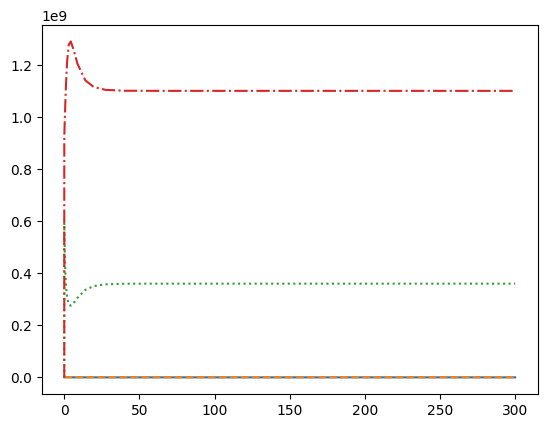

In [101]:
forward_result[1].plot()

# Misc. tests

In [ ]:
x, y, z = sympy.symbols("x y z")
sigma, rho, beta = sympy.symbols("sigma rho beta")

def f(x, y, z, sigma, rho, beta):
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z

    return dx#, dy, dz

sympy_f = f(x, y, z, sigma, rho, beta)
sympy_df_dsigma = sympy.diff(sympy_f, sigma)

sympy.ccode(sympy_df_dsigma, standard="c11")

In [ ]:
x = sympy.IndexedBase("x")
k = sympy.IndexedBase("k")

def f(x, k):
    x, y, z = x[0], x[1], x[2]
    sigma, rho, beta = k[0], k[1], k[2]

    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z

    return sympy.Matrix([dx, dy, dz])

sympy_f = f(x, k)
m = sympy_f.jacobian(sympy.Matrix([x[0], x[1], x[2]]))

In [ ]:
sympy.ccode(m, standard="c11")